# Simple 1/f noise smoothing for NIRCam images

Dan Coe

In [1]:
from astroquery.mast import Observations
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
mast_dir = 'mast:jwst/product' # Download from MAST

data_dir = 'data'  # save downloaded data
os.makedirs(data_dir, exist_ok=True)

In [3]:
image_file = "jw01345001001_10201_00001_nrca3_cal.fits"  # CEERS
mast_path  = os.path.join(mast_dir, image_file)
local_path = os.path.join(data_dir, image_file)
Observations.download_file(mast_path, local_path=local_path)

('COMPLETE', None, None)

In [4]:
# Simple 1/f noise smoothing method by Dan Coe

from astropy.stats import sigma_clipped_stats  # , SigmaClip
from astropy.convolution import convolve  # , Gaussian2DKernel, interpolate_replace_nans

def smooth_1overf_correction(data, row_kernel_length=99, column_kernel_length=9):
    # horizontal striping: y-axis row medians
    kernel = np.ones(row_kernel_length) / float(row_kernel_length)
    ymean, ymedian, ystd = sigma_clipped_stats(data, sigma=3, maxiters=10, axis=1)
    ymedian_conv = convolve(ymedian, kernel, boundary='extend')
    row_corrected_data = data + ymedian_conv[:,np.newaxis] - ymedian[:,np.newaxis]
    
    # vertical striping: x-axis column medians
    kernel = np.ones(column_kernel_length) / float(column_kernel_length)
    xmean, xmedian, xstd = sigma_clipped_stats(row_corrected_data, sigma=3, maxiters=10, axis=0)
    xmedian_conv = convolve(xmedian, kernel, boundary='extend')
    corrected_data = row_corrected_data + xmedian_conv[np.newaxis,:] - xmedian[np.newaxis,:]

    return corrected_data

In [5]:
input_file = local_path
hdu_list = fits.open(input_file)
data = hdu_list['SCI'].data
output_file = input_file.replace('cal.fits', 'cal1f.fits')
if not os.path.exists(output_file):
    corrected_data = smooth_1overf_correction(data)
    hdu_list['SCI'].data = corrected_data
    hdu_list.writeto(output_file)

In [7]:
import matplotlib.pyplot as plt

def display_images(image_data, corrected_data, vmin, vmax, corrected_title, filename, xsize=12, ysize=12, aspect=1, cmap='viridis',
                  save_plot=None, dpi=150):
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes',  labelsize=10)
    plt.rc('axes',  titlesize=12)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True, layout='compressed')
    axs = axs.flatten()
    
    plot_data = image_data, corrected_data
    
    for i in range(2):
        data = plot_data[i]
        data = np.nan_to_num(data)  # replace nan with zero
        im = axs[i].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
    
    axs[0].set_title(os.path.basename(filename), fontsize=12)
    axs[1].set_title(corrected_title, fontsize=12)
    
    plt.colorbar(im, ax=axs, label='MJy/sr')
    
    if save_plot:
        output_file = save_plot
        plt.savefig(output_file, dpi=dpi)

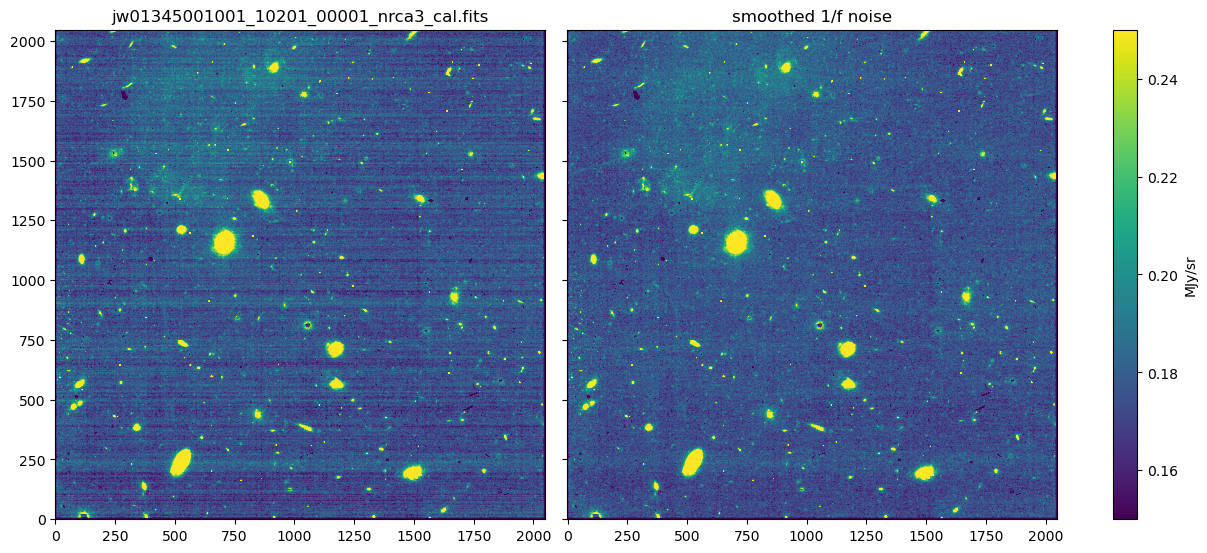

In [8]:
vmin, vmax = 0.15, 0.25
display_images(data, corrected_data, vmin, vmax, 'smoothed 1/f noise', image_file)